# Plot Fragility Heatmaps of the Analyzed TVB Simulations

In [1]:
# auto-format every cell to black
%load_ext lab_black

In [2]:
import numpy as np
import pandas as pd
import mne
from pprint import pprint
from natsort import natsorted

import os
import json
import os.path as op
from pathlib import Path
import collections

from mne_bids import BIDSPath, get_entity_vals, read_raw_bids

mne.utils.use_log_level("error")

import ptitprince as pt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import scipy

from eztrack.io.base import _add_desc_to_bids_fname, concatenate_derivs
from eztrack.io import read_derivative_npy, create_deriv_info, DerivativeArray
from eztrack.fragility import (
    lds_raw_fragility,
    DiscreteLinearSystem,
    SystemIDModel,
    StructuredPerturbationModel,
)
from eztrack.viz import generate_heatmap

# %matplotlib widget
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Set Parameters and Path

In [3]:
np.random.seed(12345)

In [4]:
# paths to data
root = Path("/Users/adam2392/Dropbox/resection_tvb/")
source_path = root / "sourcedata"
experimental_condition = "epilepsy"
subject = "id008gc"
subject = "id013pg"  # patient id with successful resection

subj_path = source_path / experimental_condition / subject
source_file = subj_path / "tvb" / "connectivity.zip"

In [5]:
output_path = Path("/Users/adam2392/OneDrive - Johns Hopkins/sickkids/derivatives/tvb")
output_path.mkdir(exist_ok=True, parents=True)

figures_path = output_path / "metafigures"

print(subject)
print(output_path)

id013pg
/Users/adam2392/OneDrive - Johns Hopkins/sickkids/derivatives/tvb


In [6]:
# how to combine resting state 2D oscillator and Epileptor LFP values
p = 0.2

# derivative type
# column perturbations
derivtype = "col"

## Create Output File Paths (Initial conditions, and output simulations)

In [7]:
# make sure subject doesn't have '_' character
subject = subject.replace("_", "")
print(subject)

# save data and the sEEG projections
rawsim_bids_path = BIDSPath(
    subject=subject,
    session="preresection",
    task="tvbsimezpz",
    acquisition="rs",
    suffix="ieeg",
    run="01",
    extension=".npz",
    check=False,
)
print(f"This is the filename that we will eventually save {rawsim_bids_path.basename}")

id013pg
This is the filename that we will eventually save sub-id013pg_ses-preresection_task-tvbsimezpz_acq-rs_run-01_ieeg.npz


In [8]:
# create a file path to save initial conditions to
initial_bids_path = BIDSPath(
    subject=subject,
    session="preresection",
    task="rs",
    suffix="epileptoric",
    extension=".npy",
    check=False,
)

print(f"Initial conditions: {initial_bids_path}")

Initial conditions: sub-id013pg/ses-preresection/sub-id013pg_ses-preresection_task-rs_epileptoric.npy


In [9]:
# save data and the sEEG projections
succ_resect_bids_path = BIDSPath(
    subject=subject,
    session="postresection",
    task="tvbsimezpz",
    suffix="ieeg",
    run="01",
    extension=".npz",
    check=False,
)
print(succ_resect_bids_path.basename)

# save data and the sEEG projections
partial_resect_bids_path = BIDSPath(
    subject=subject,
    session="postresection",
    task="tvbsimezpz",
    suffix="ieeg",
    run="02",
    extension=".npz",
    check=False,
)

fail_resect_bids_path = BIDSPath(
    subject=subject,
    session="postresection",
    task="tvbsimezpz",
    suffix="ieeg",
    run="03",
    extension=".npz",
    check=False,
)

sub-id013pg_ses-postresection_task-tvbsimezpz_run-01_ieeg.npz


In [10]:
desc = "perturbmatrix"

deriv_output_path = output_path / "fragility"
deriv_output_path.mkdir(exist_ok=True)
print(deriv_output_path)

# save data and the sEEG projections
deriv_base_path = BIDSPath(
    subject=subject,
    session="preresection",
    task="tvbsimezpz",
    acquisition="rs",
    suffix="ieeg",
    run="01",
    extension=".npy",
    check=False,
)
deriv_base_path = _add_desc_to_bids_fname(deriv_base_path, desc)

# save data and the sEEG projections
deriv_succ_resect_path = BIDSPath(
    subject=subject,
    session="postresection",
    task="tvbsimezpz",
    suffix="ieeg",
    run="01",
    extension=".npy",
    check=False,
)
deriv_succ_resect_path = _add_desc_to_bids_fname(deriv_succ_resect_path, desc)
print(succ_resect_bids_path.basename)

# save data and the sEEG projections
deriv_partial_resect_path = BIDSPath(
    subject=subject,
    session="postresection",
    task="tvbsimezpz",
    suffix="ieeg",
    run="02",
    extension=".npy",
    check=False,
)
deriv_partial_resect_path = _add_desc_to_bids_fname(deriv_partial_resect_path, desc)

deriv_fail_resect_path = BIDSPath(
    subject=subject,
    session="postresection",
    task="tvbsimezpz",
    suffix="ieeg",
    run="03",
    extension=".npy",
    check=False,
)
deriv_fail_resect_path = _add_desc_to_bids_fname(deriv_fail_resect_path, desc)

/Users/adam2392/OneDrive - Johns Hopkins/sickkids/derivatives/tvb/fragility
sub-id013pg_ses-postresection_task-tvbsimezpz_run-01_ieeg.npz


# Load Data and Plot

In [11]:
# read the original non-resected data
pert_deriv = read_derivative_npy(deriv_output_path / deriv_base_path, preload=True)

(<Figure size 1800x1800 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

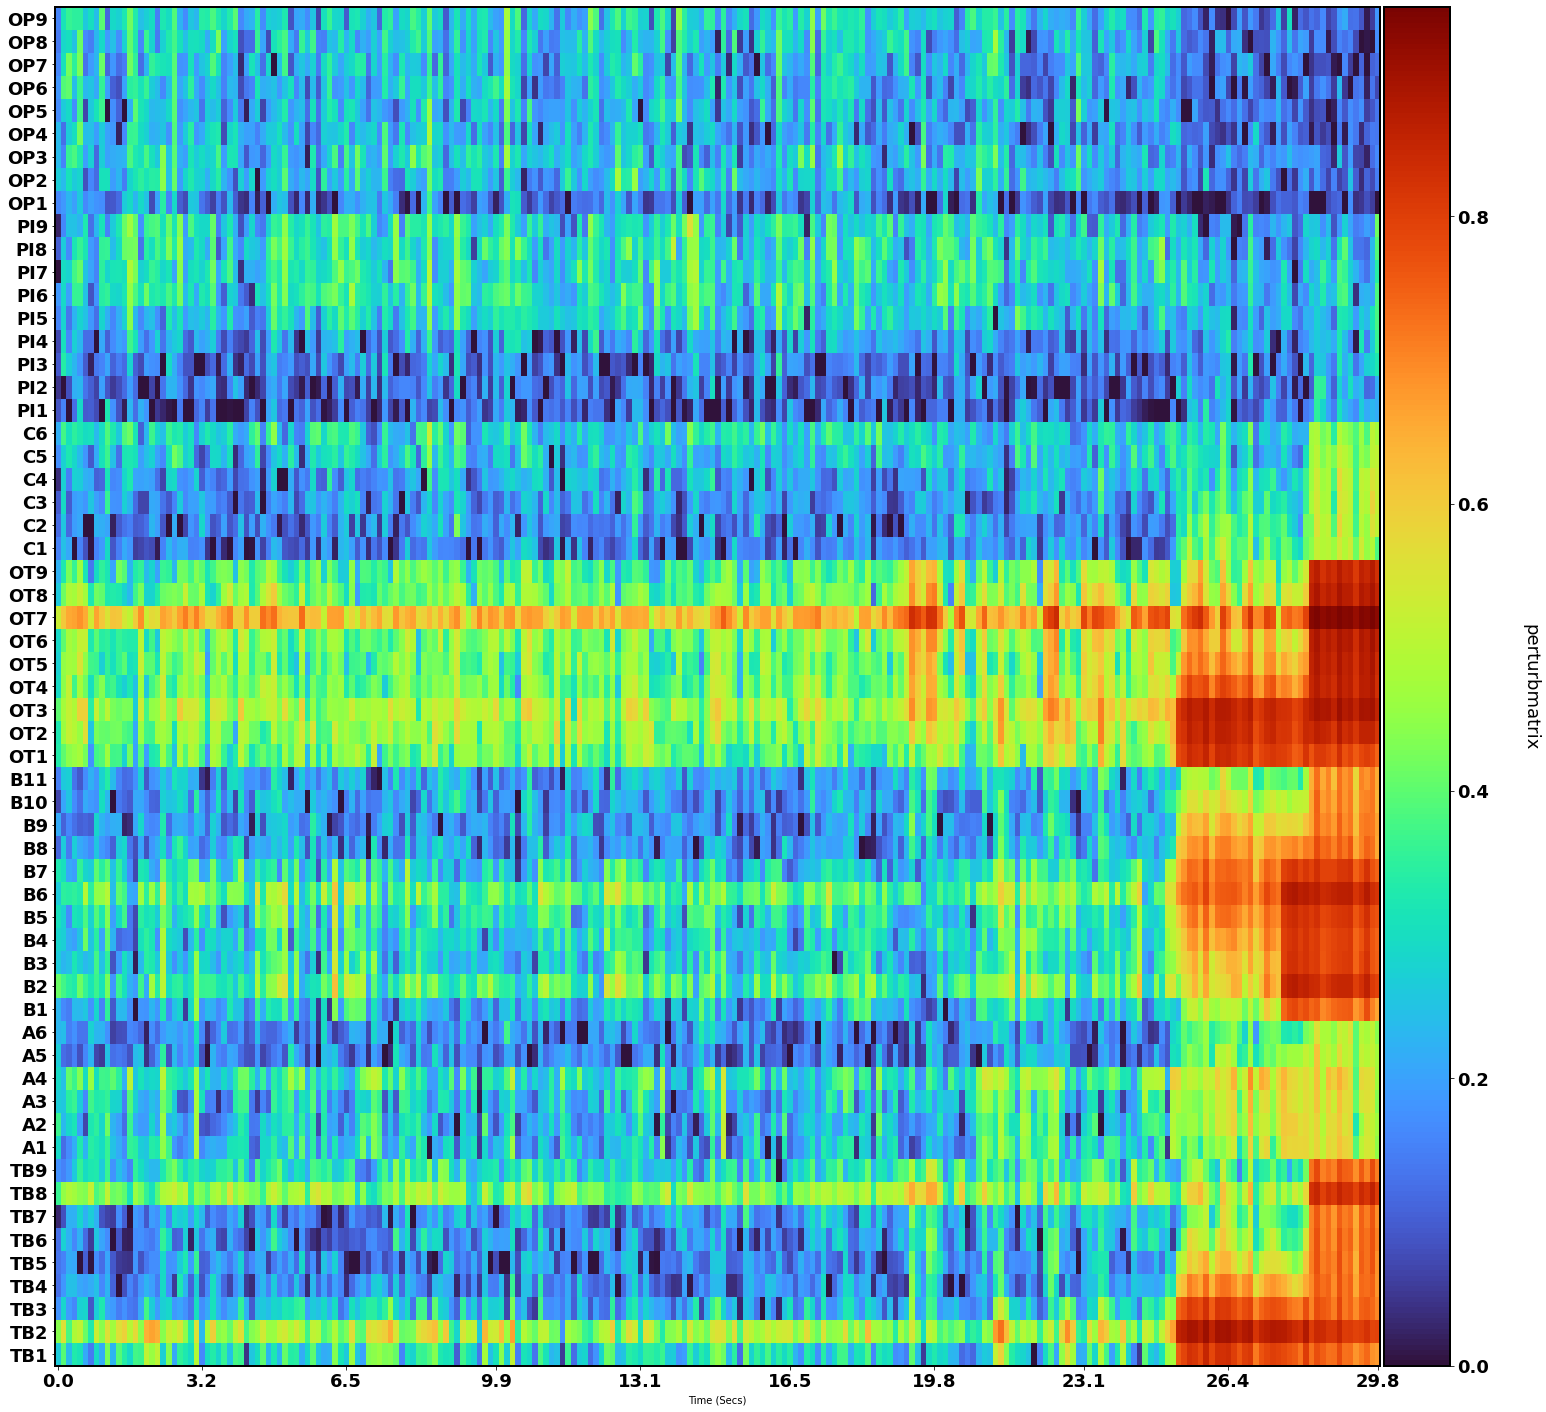

In [12]:
pert_deriv.normalize()
pert_deriv.plot_heatmap()

## Successful Resection

In [13]:
# read the original non-resected data
pert_deriv = read_derivative_npy(deriv_output_path / deriv_succ_resect_path, preload=True)

(<Figure size 1800x1800 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

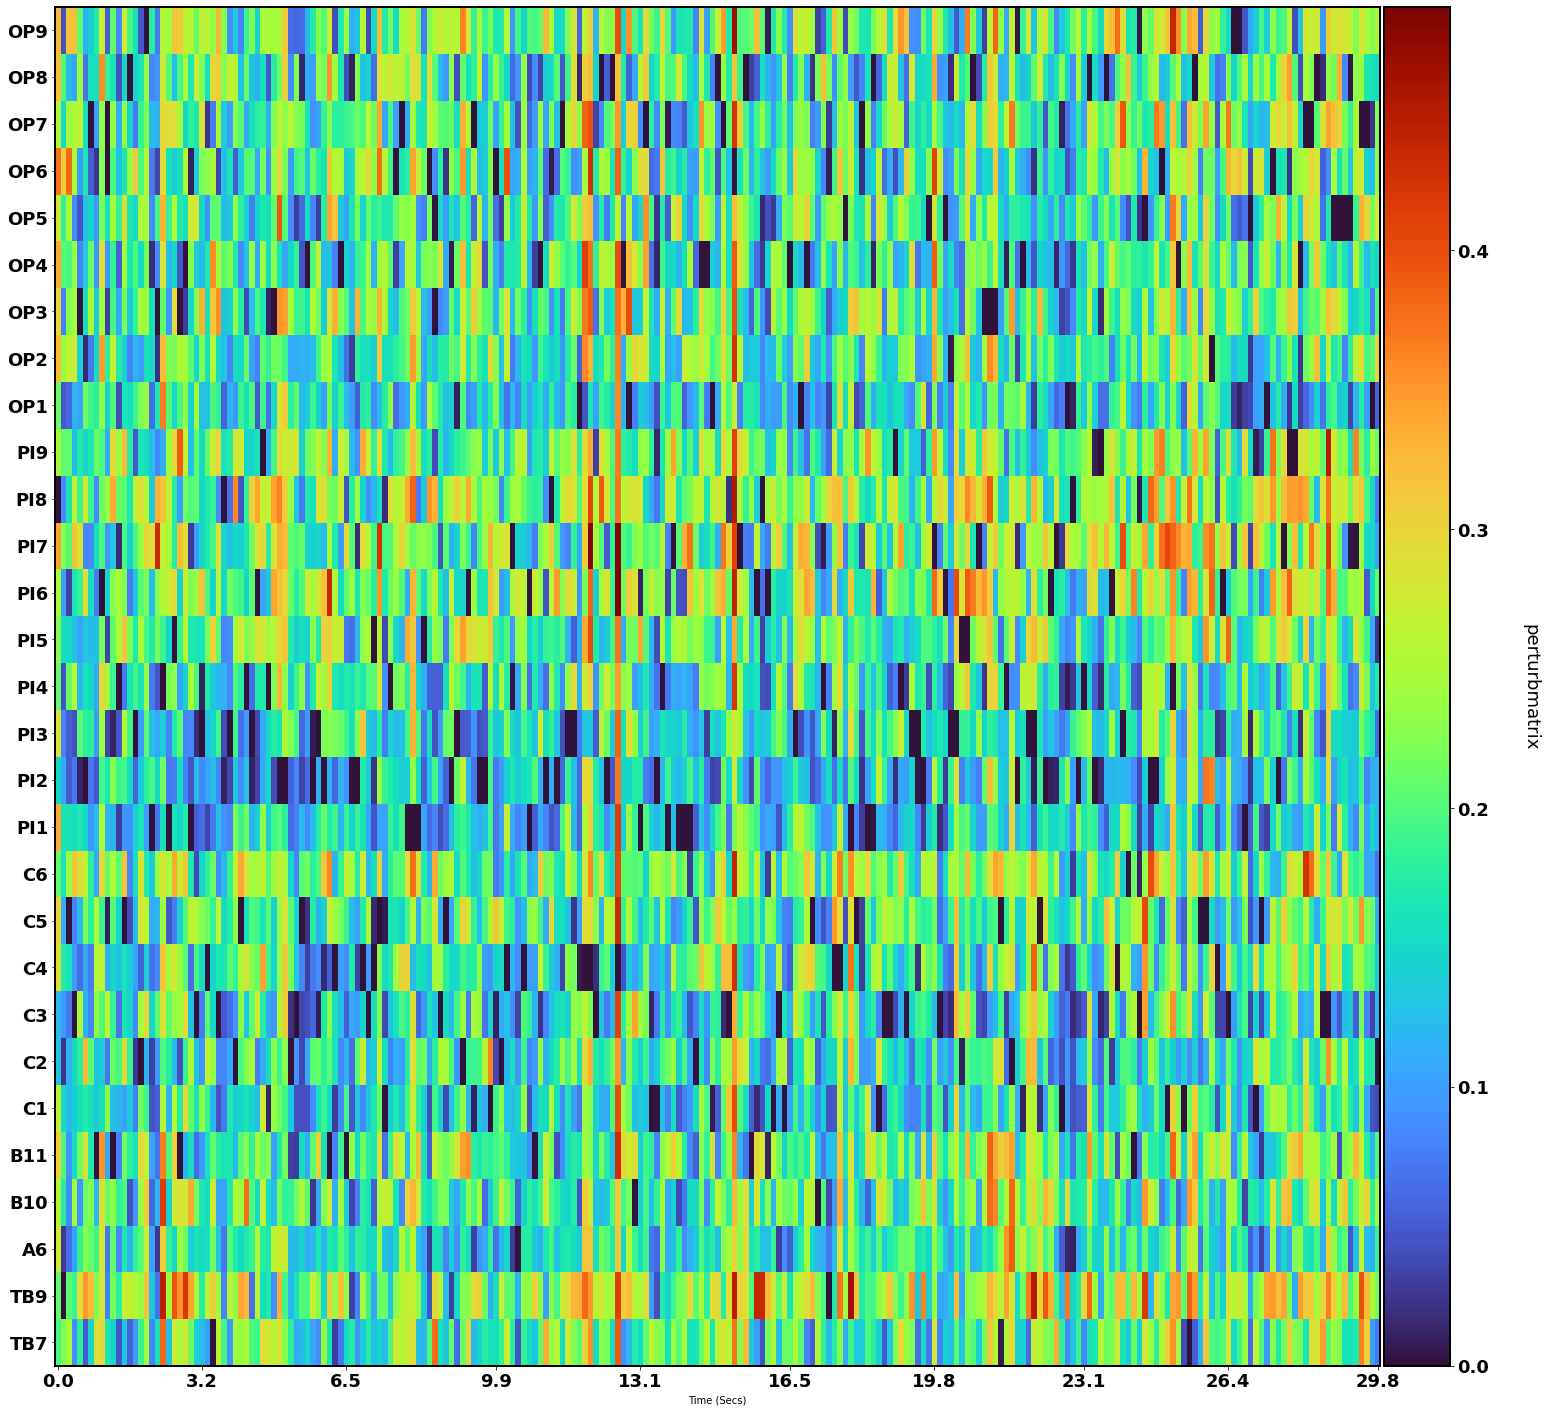

In [14]:
pert_deriv.normalize()
pert_deriv.plot_heatmap()

## Partial Resection

In [15]:
# read the original non-resected data
pert_deriv = read_derivative_npy(deriv_output_path / deriv_partial_resect_path, preload=True)

(<Figure size 1800x1800 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

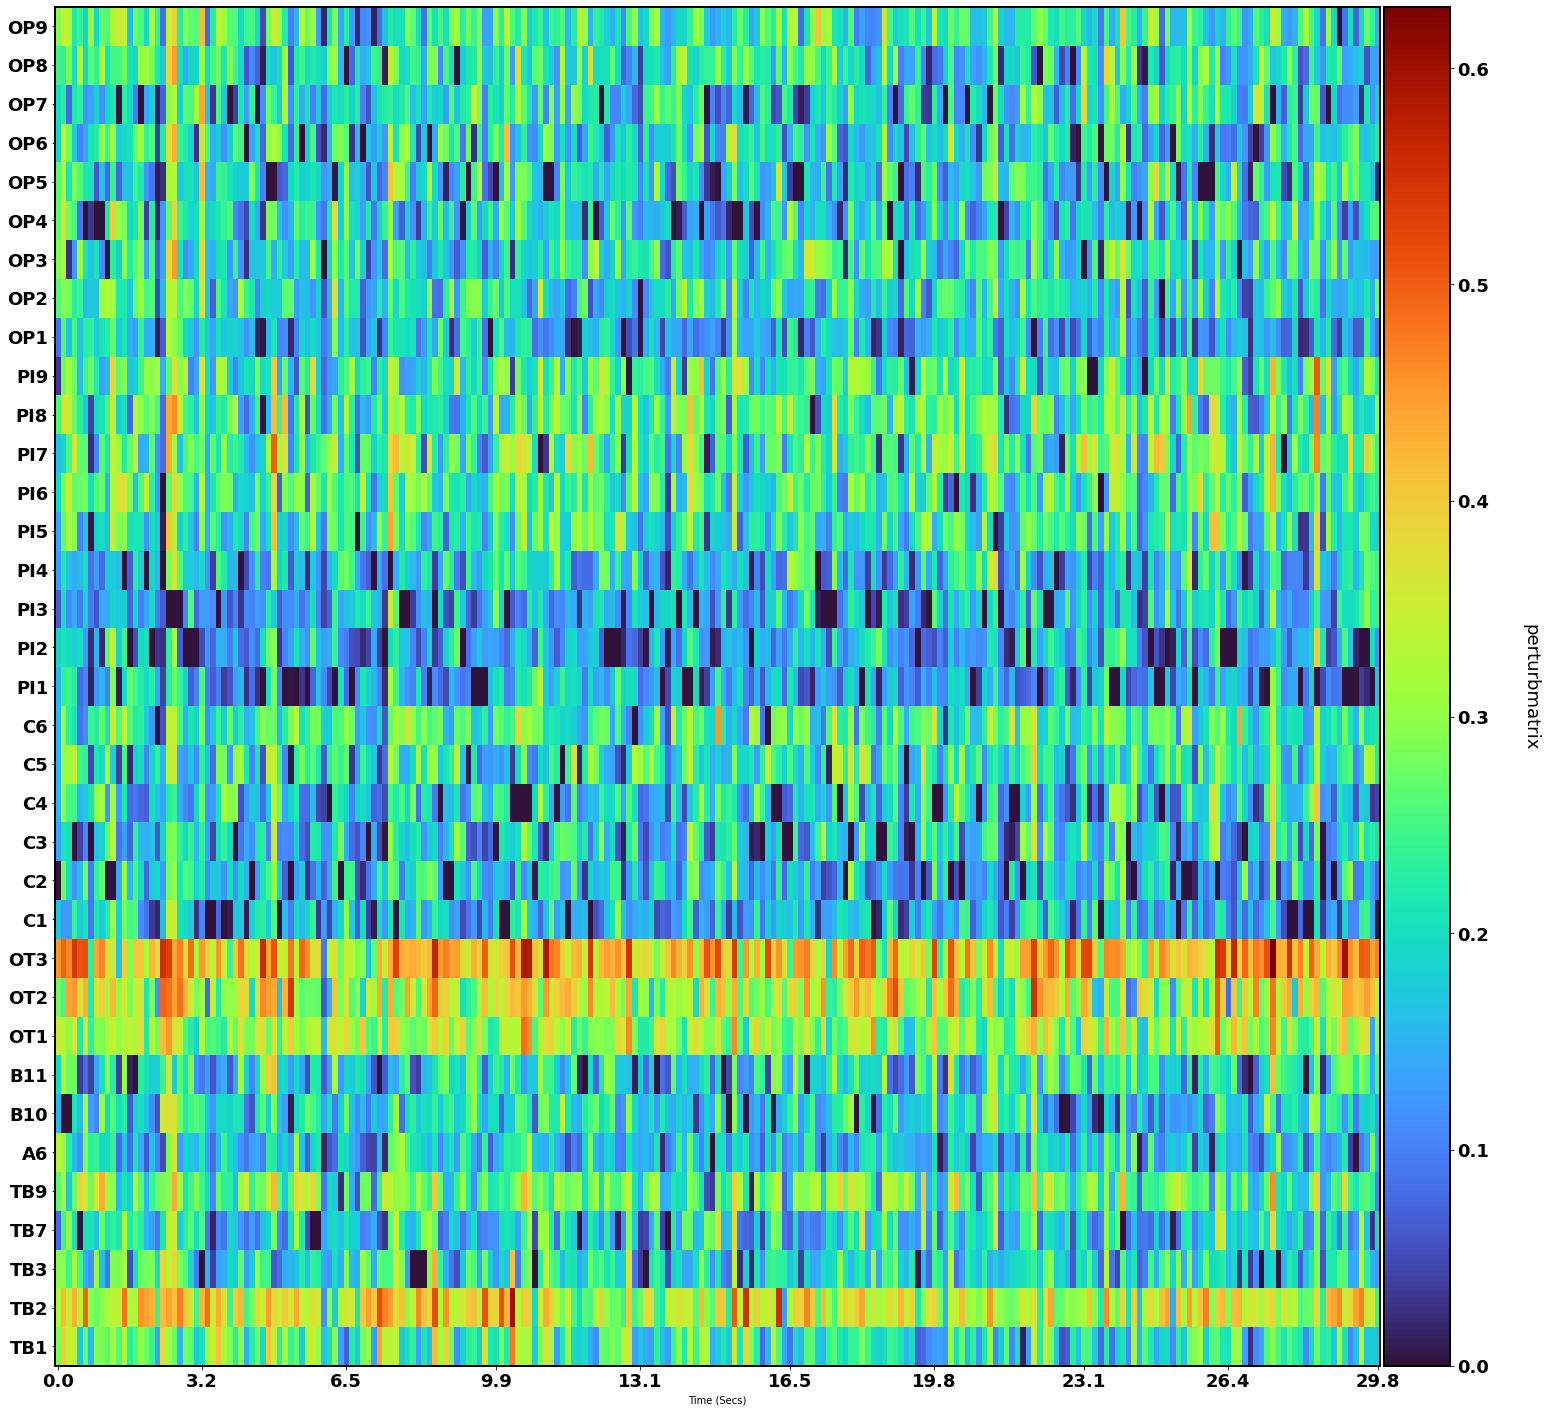

In [16]:
pert_deriv.normalize()
pert_deriv.plot_heatmap()

## Failed Resection

In [17]:
# read the original non-resected data
pert_deriv = read_derivative_npy(deriv_output_path / deriv_fail_resect_path, preload=True)

(<Figure size 1800x1800 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

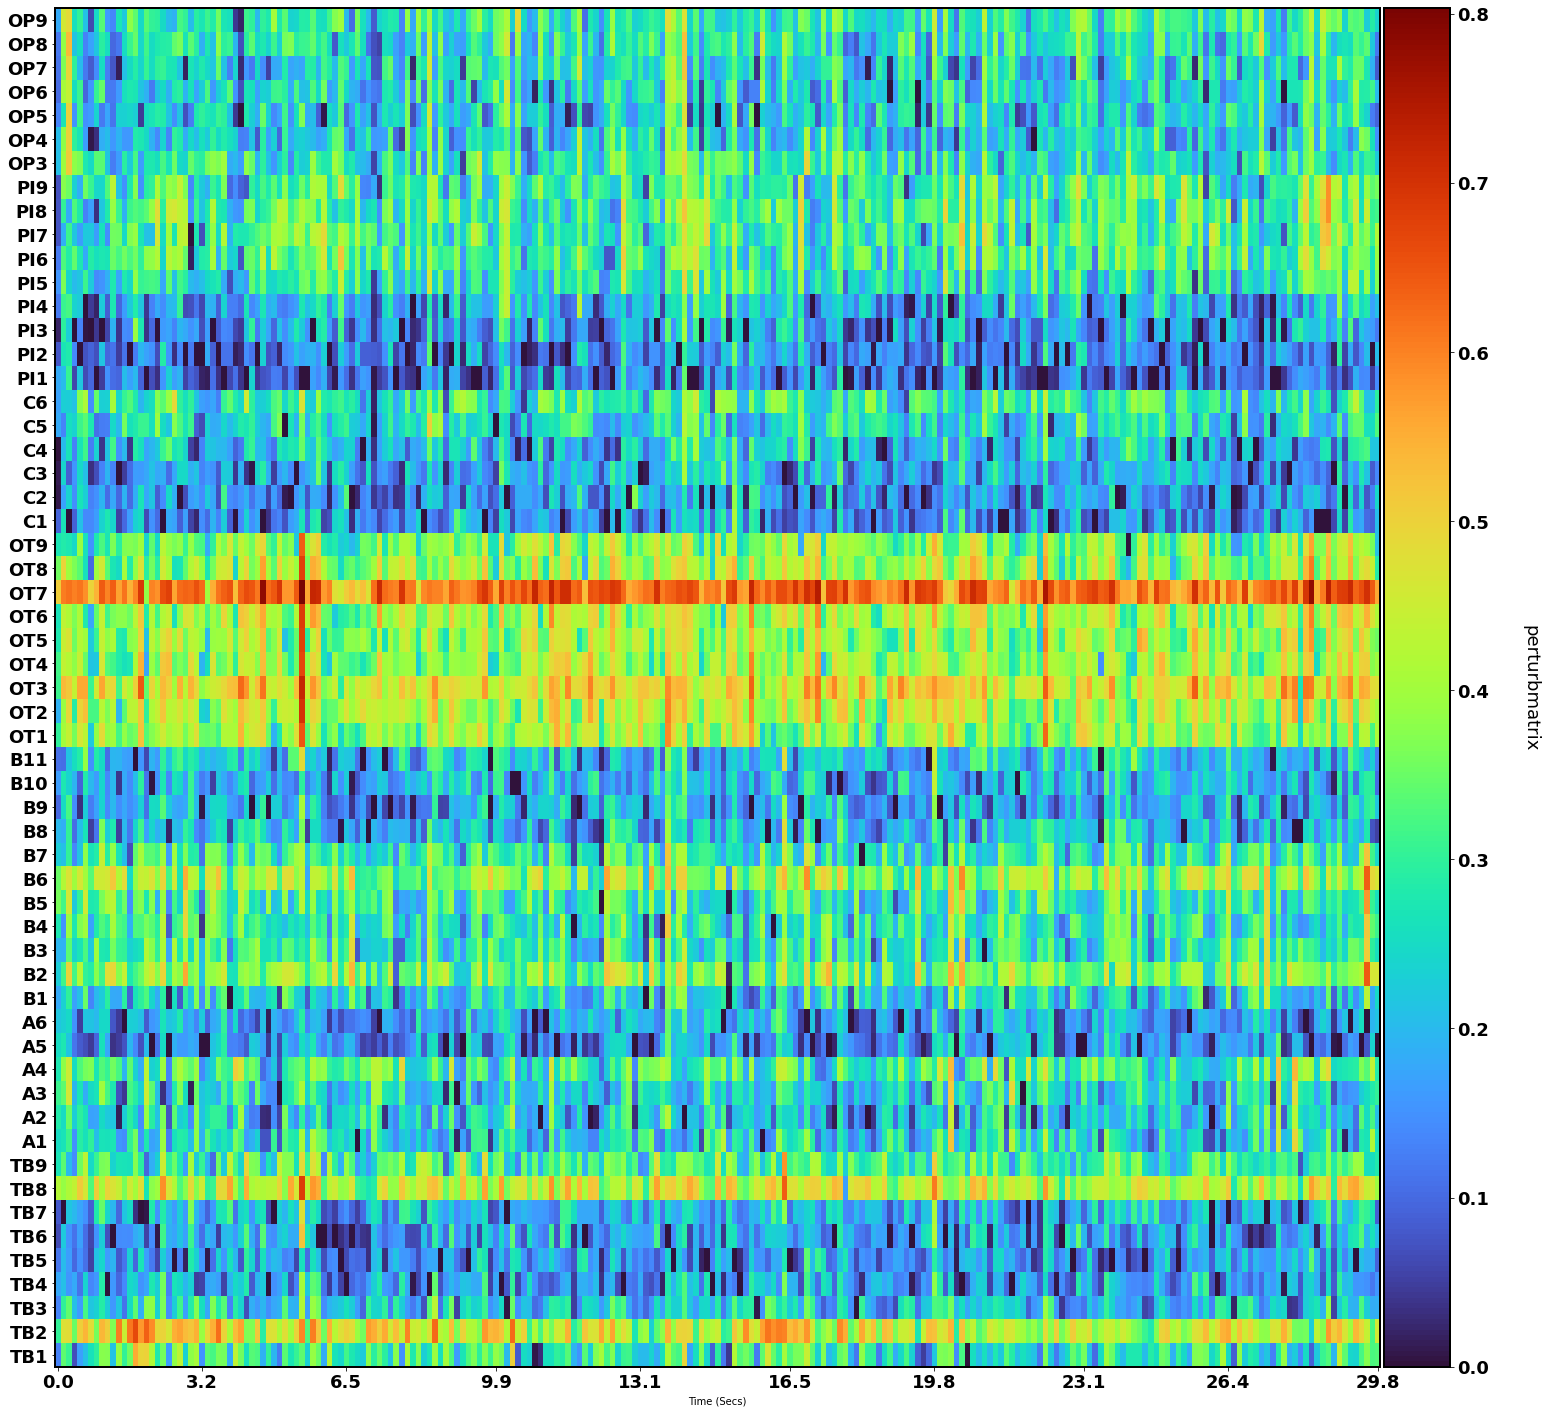

In [18]:
pert_deriv.normalize()
pert_deriv.plot_heatmap()

# Plot Heatmaps Concatenated Next To Each Other

In [12]:
pre_deriv = read_derivative_npy(deriv_output_path / deriv_base_path)
succ_deriv = read_derivative_npy(deriv_output_path / deriv_succ_resect_path)
partial_deriv = read_derivative_npy(deriv_output_path / deriv_partial_resect_path)
fail_deriv = read_derivative_npy(deriv_output_path / deriv_fail_resect_path)

# crop pre_deriv to get rid of the start of seizure period
pre_deriv.load_data()
succ_deriv.load_data()
partial_deriv.load_data()
fail_deriv.load_data()

pre_deriv.normalize()
succ_deriv.normalize()
partial_deriv.normalize()
fail_deriv.normalize()
print(len(pre_deriv))
pre_deriv = pre_deriv.crop(tmin=0, tmax=25)
print(len(pre_deriv))
print(pre_deriv._first_samps, pre_deriv._last_samps)

239
201
[0] [200]


In [21]:
def add_derivatives(deriv1, deriv2):
    deriv1 = deriv1.copy()
    deriv2 = deriv2.copy()

    deriv1.load_data()
    deriv2.load_data()

    deriv1.normalize()
    deriv2.normalize()

    if not all([ch in deriv1.ch_names for ch in deriv2.ch_names]):
        # get the set difference of channels
        add_chs = list(set(deriv2.ch_names) - set(deriv1.ch_names))
        ch_type = deriv2.get_channel_types()[0]
        info = create_deriv_info(
            ch_names=add_chs,
            sfreq=deriv2.info["sfreq"],
            ch_types=ch_type,
            description=deriv2.description,
            ch_axis=[0],
        )
        addderiv = DerivativeArray(
            np.ones((len(add_chs), len(deriv1))) * np.nan, info=info, verbose=False
        )

        # add derivative chs
        deriv1 = deriv1.add_channels([addderiv])

        deriv2.reorder_channels(deriv2.ch_names)

    derivs = [deriv2, deriv1]
    new_deriv = concatenate_derivs(derivs)
    return new_deriv

In [22]:
presucc_deriv = add_derivatives(succ_deriv, pre_deriv)
prepart_deriv = add_derivatives(partial_deriv, pre_deriv)
prefail_deriv = add_derivatives(fail_deriv, pre_deriv)

/Users/adam2392/Documents/eztrack/eztrack/utils/_logging.py:133: RuntimeWarning: Already normalized Derivative!
  mne_warn(message, category, module)
/Users/adam2392/Documents/eztrack/eztrack/utils/_logging.py:133: RuntimeWarning: Already normalized Derivative!
  mne_warn(message, category, module)
/Users/adam2392/Documents/eztrack/eztrack/utils/_logging.py:133: RuntimeWarning: Already normalized Derivative!
  mne_warn(message, category, module)
/Users/adam2392/Documents/eztrack/eztrack/utils/_logging.py:133: RuntimeWarning: Already normalized Derivative!
  mne_warn(message, category, module)
/Users/adam2392/Documents/eztrack/eztrack/utils/_logging.py:133: RuntimeWarning: Already normalized Derivative!
  mne_warn(message, category, module)
/Users/adam2392/Documents/eztrack/eztrack/utils/_logging.py:133: RuntimeWarning: Already normalized Derivative!
  mne_warn(message, category, module)


(<Figure size 1800x1800 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

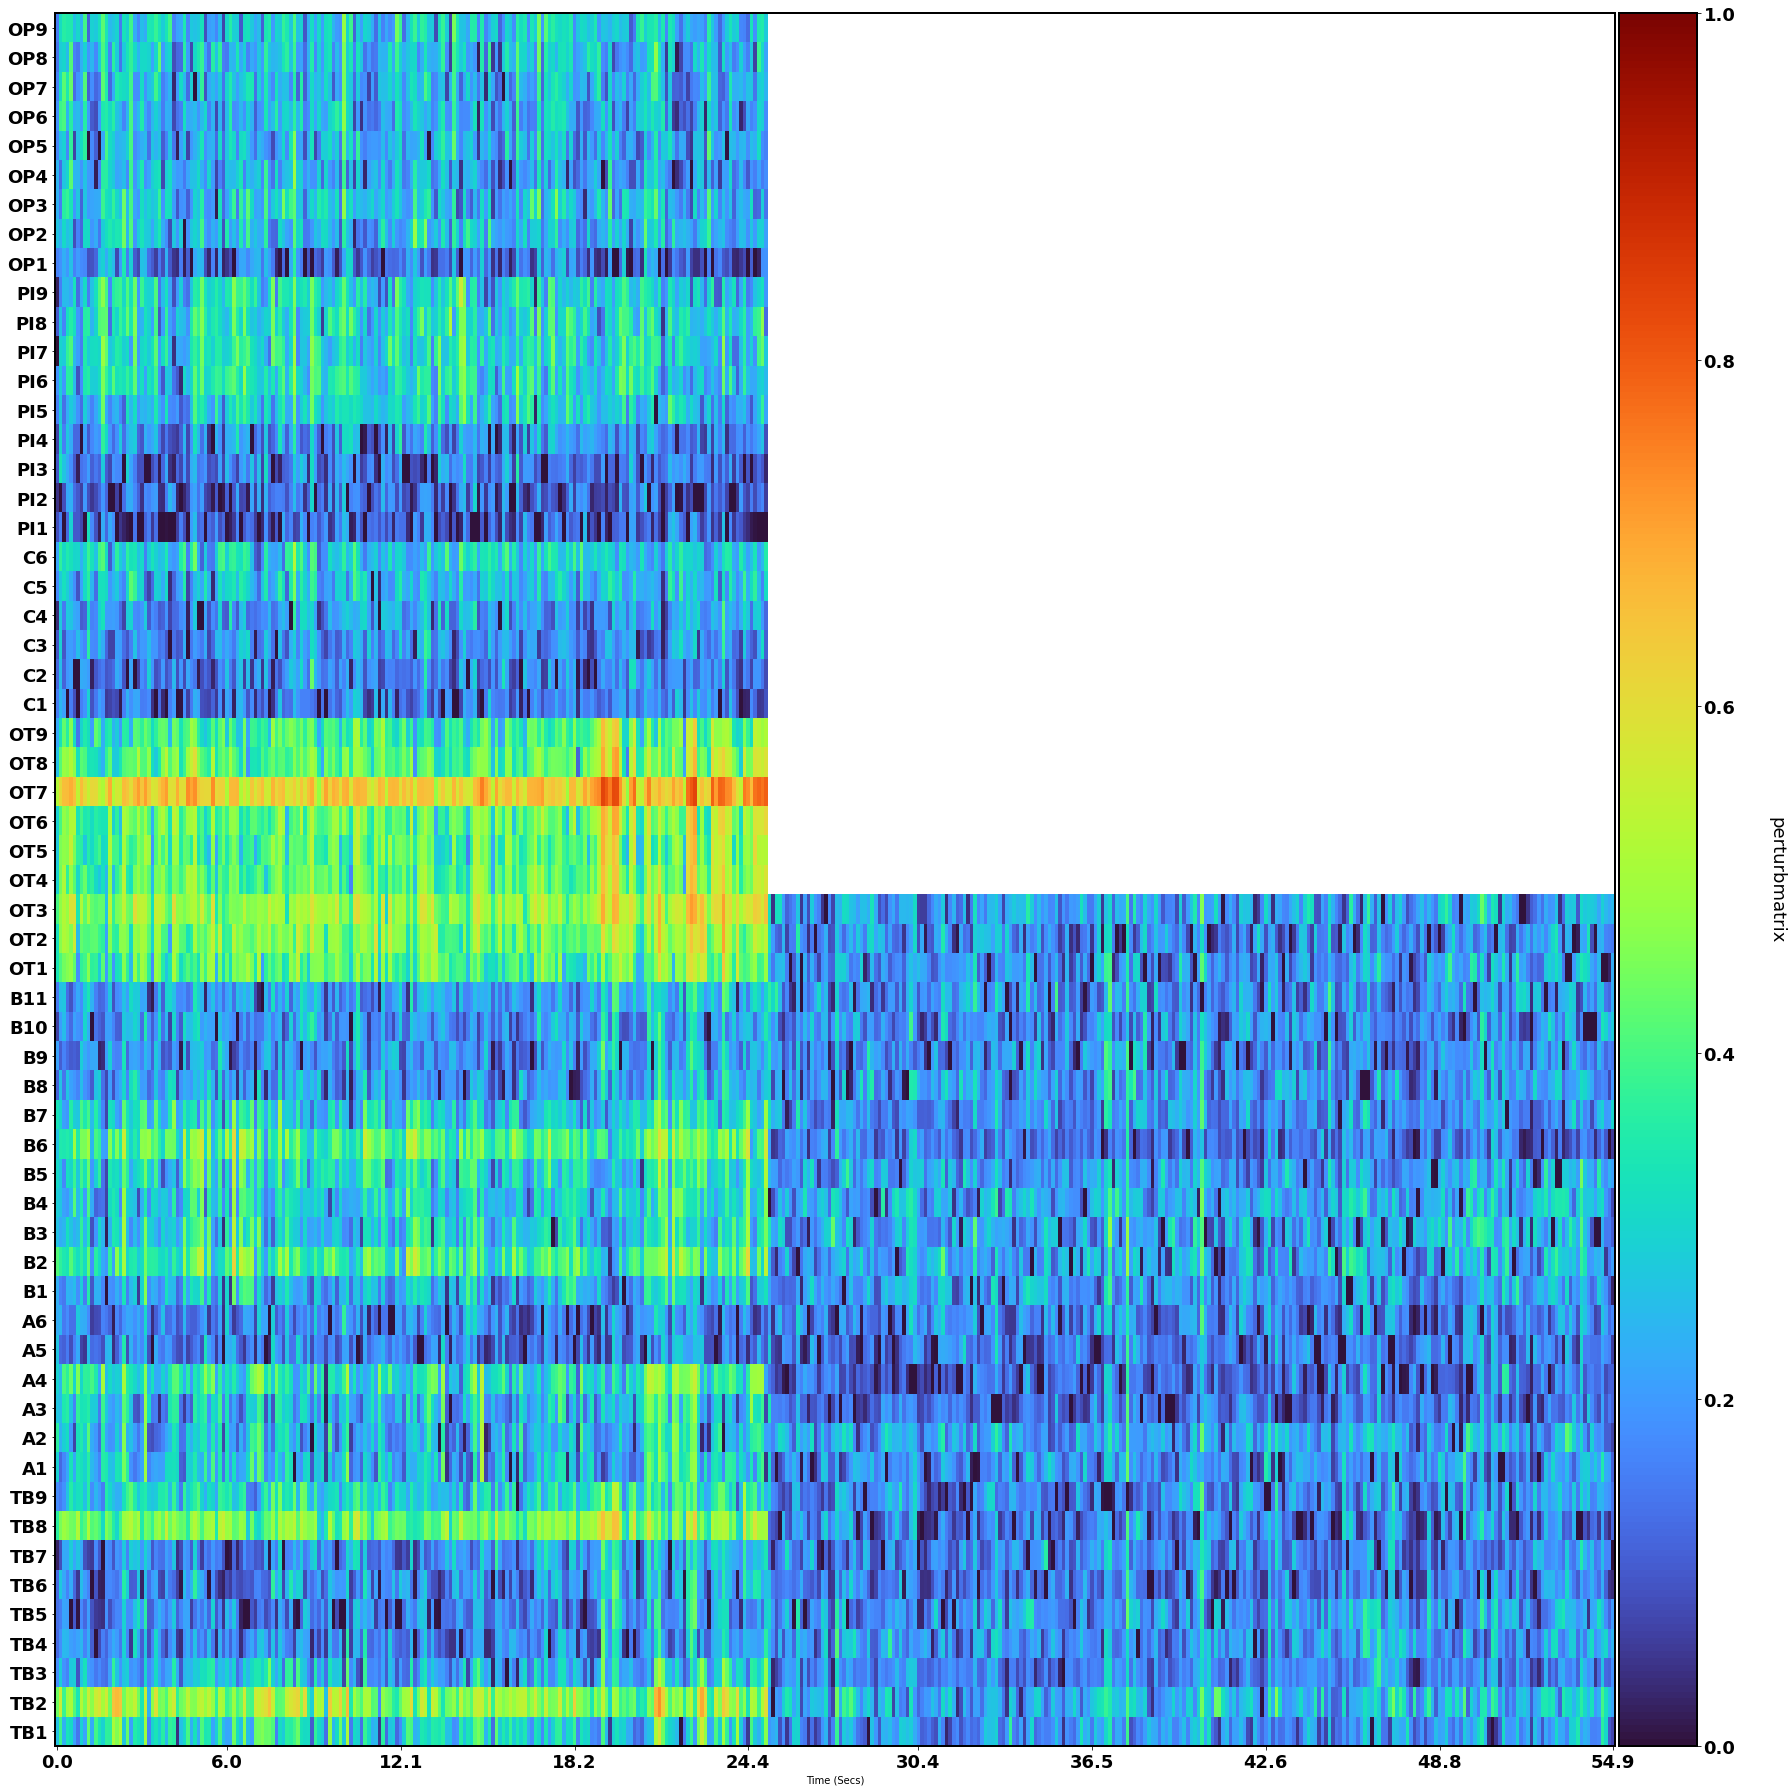

In [24]:
presucc_deriv.plot_heatmap(
    vmin=0,
    vmax=1,
    
    set_col_under=False,
    figure_fpath=figures_path / f"{subject}-successfulresection-fragilityheatmap.pdf",
)

(<Figure size 1800x1800 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

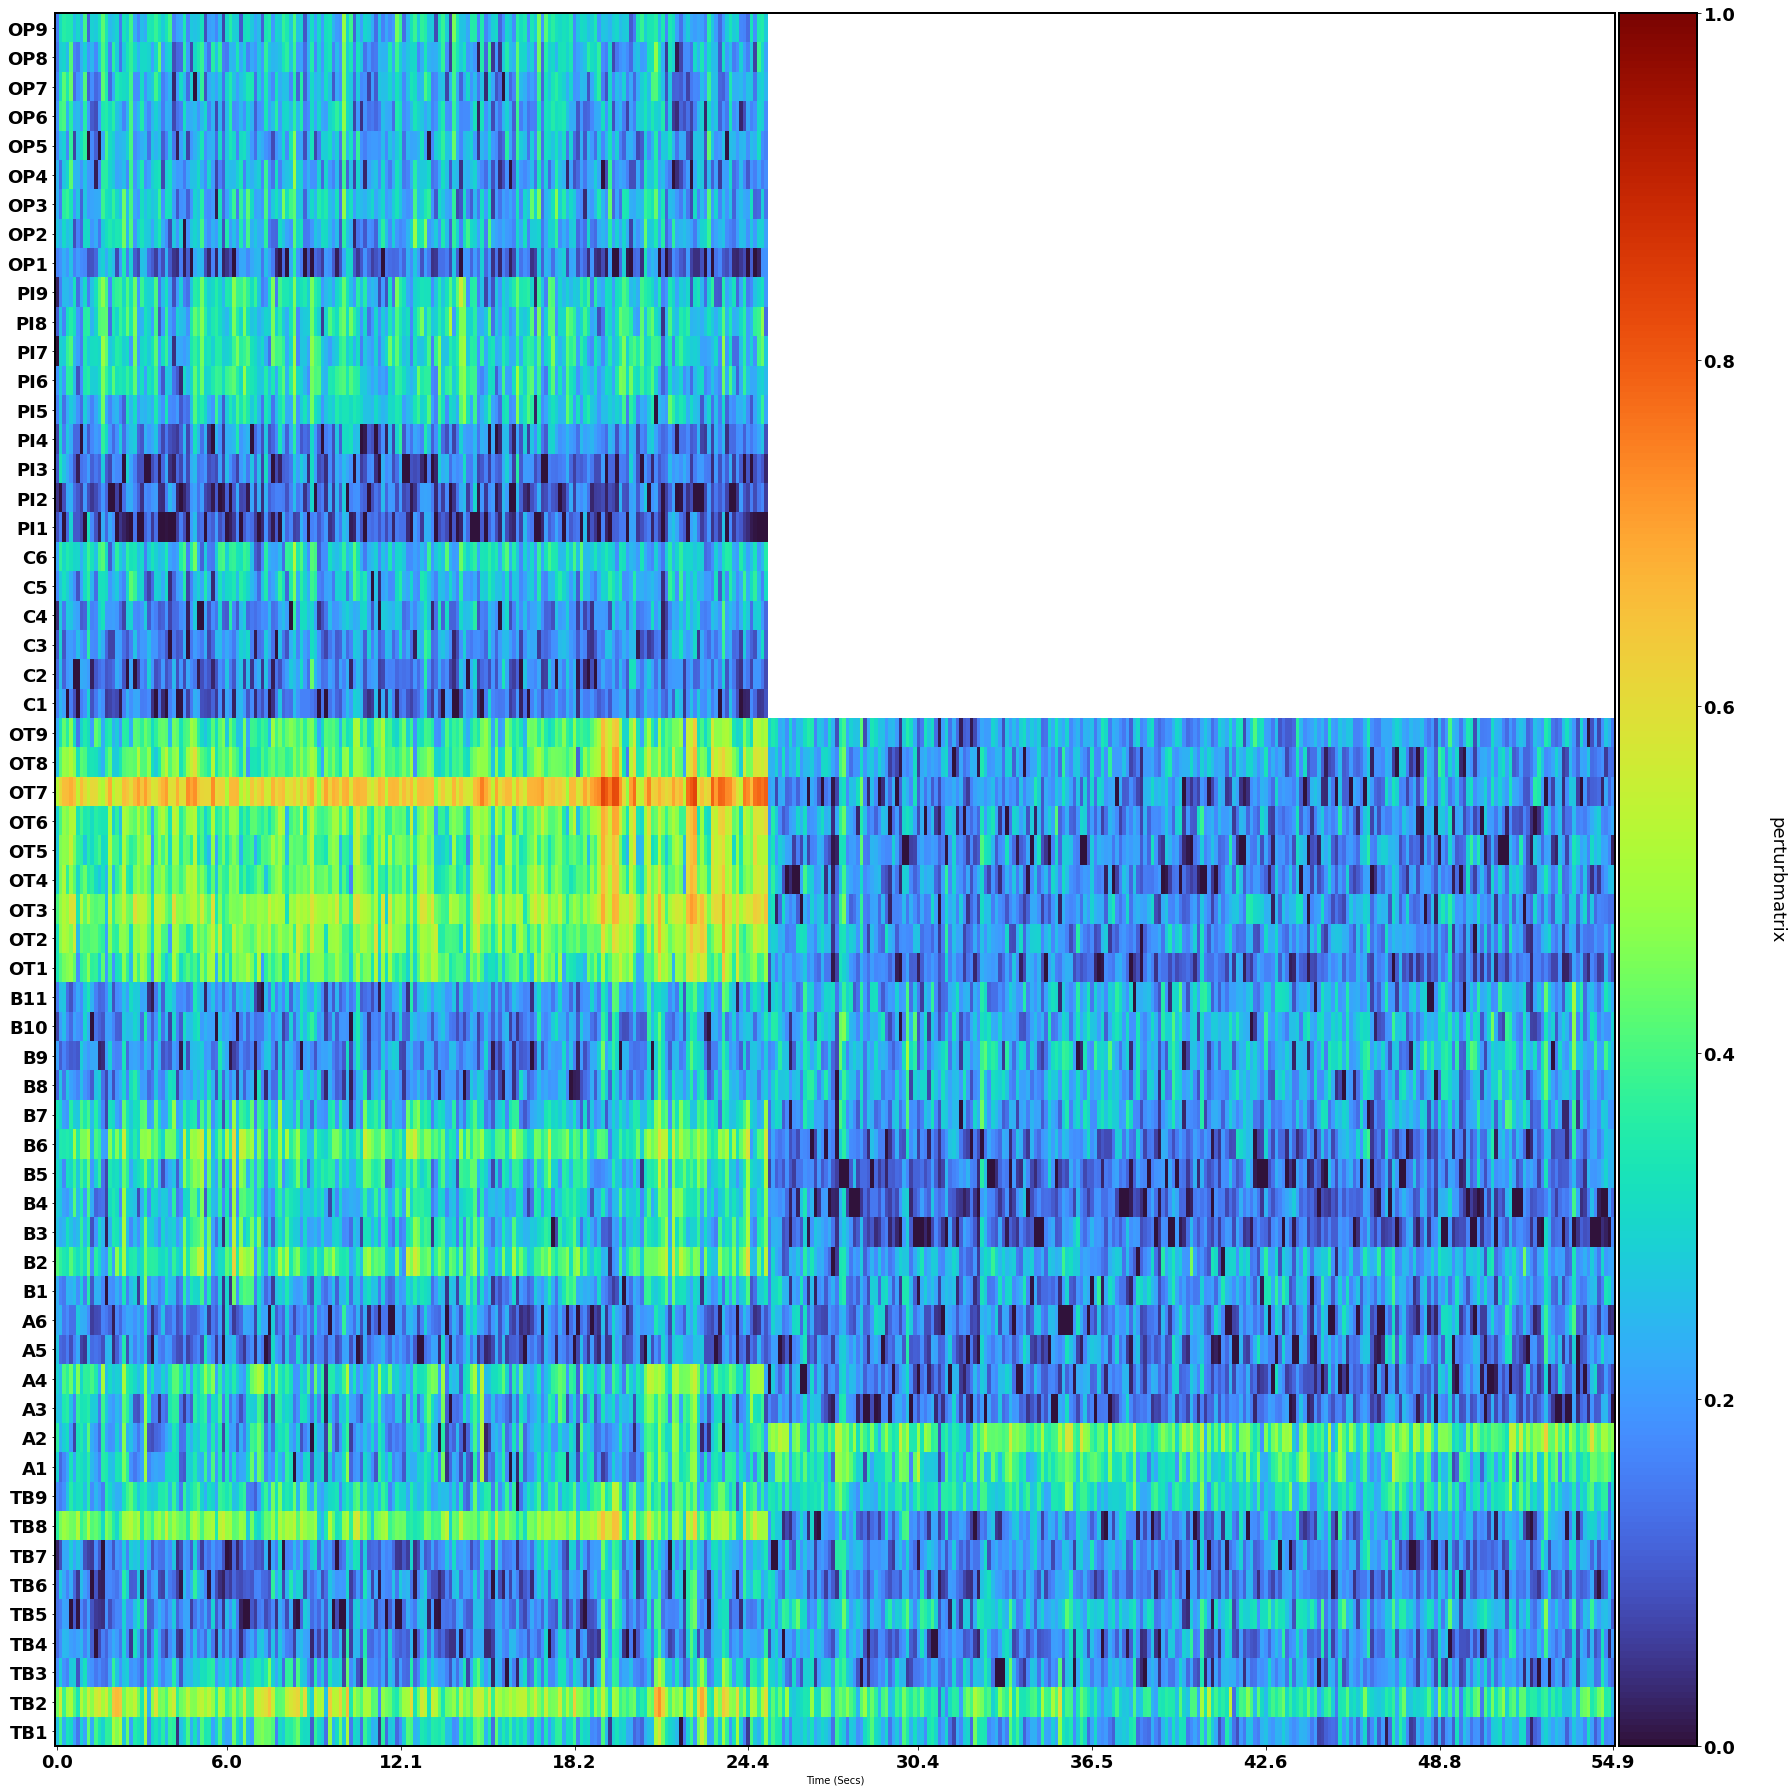

In [25]:
prepart_deriv.plot_heatmap(
    vmin=0,
    vmax=1,
    set_col_under=True,
    figure_fpath=figures_path / f"{subject}-partialfailresection-fragilityheatmap.pdf",
)

(<Figure size 1800x1800 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

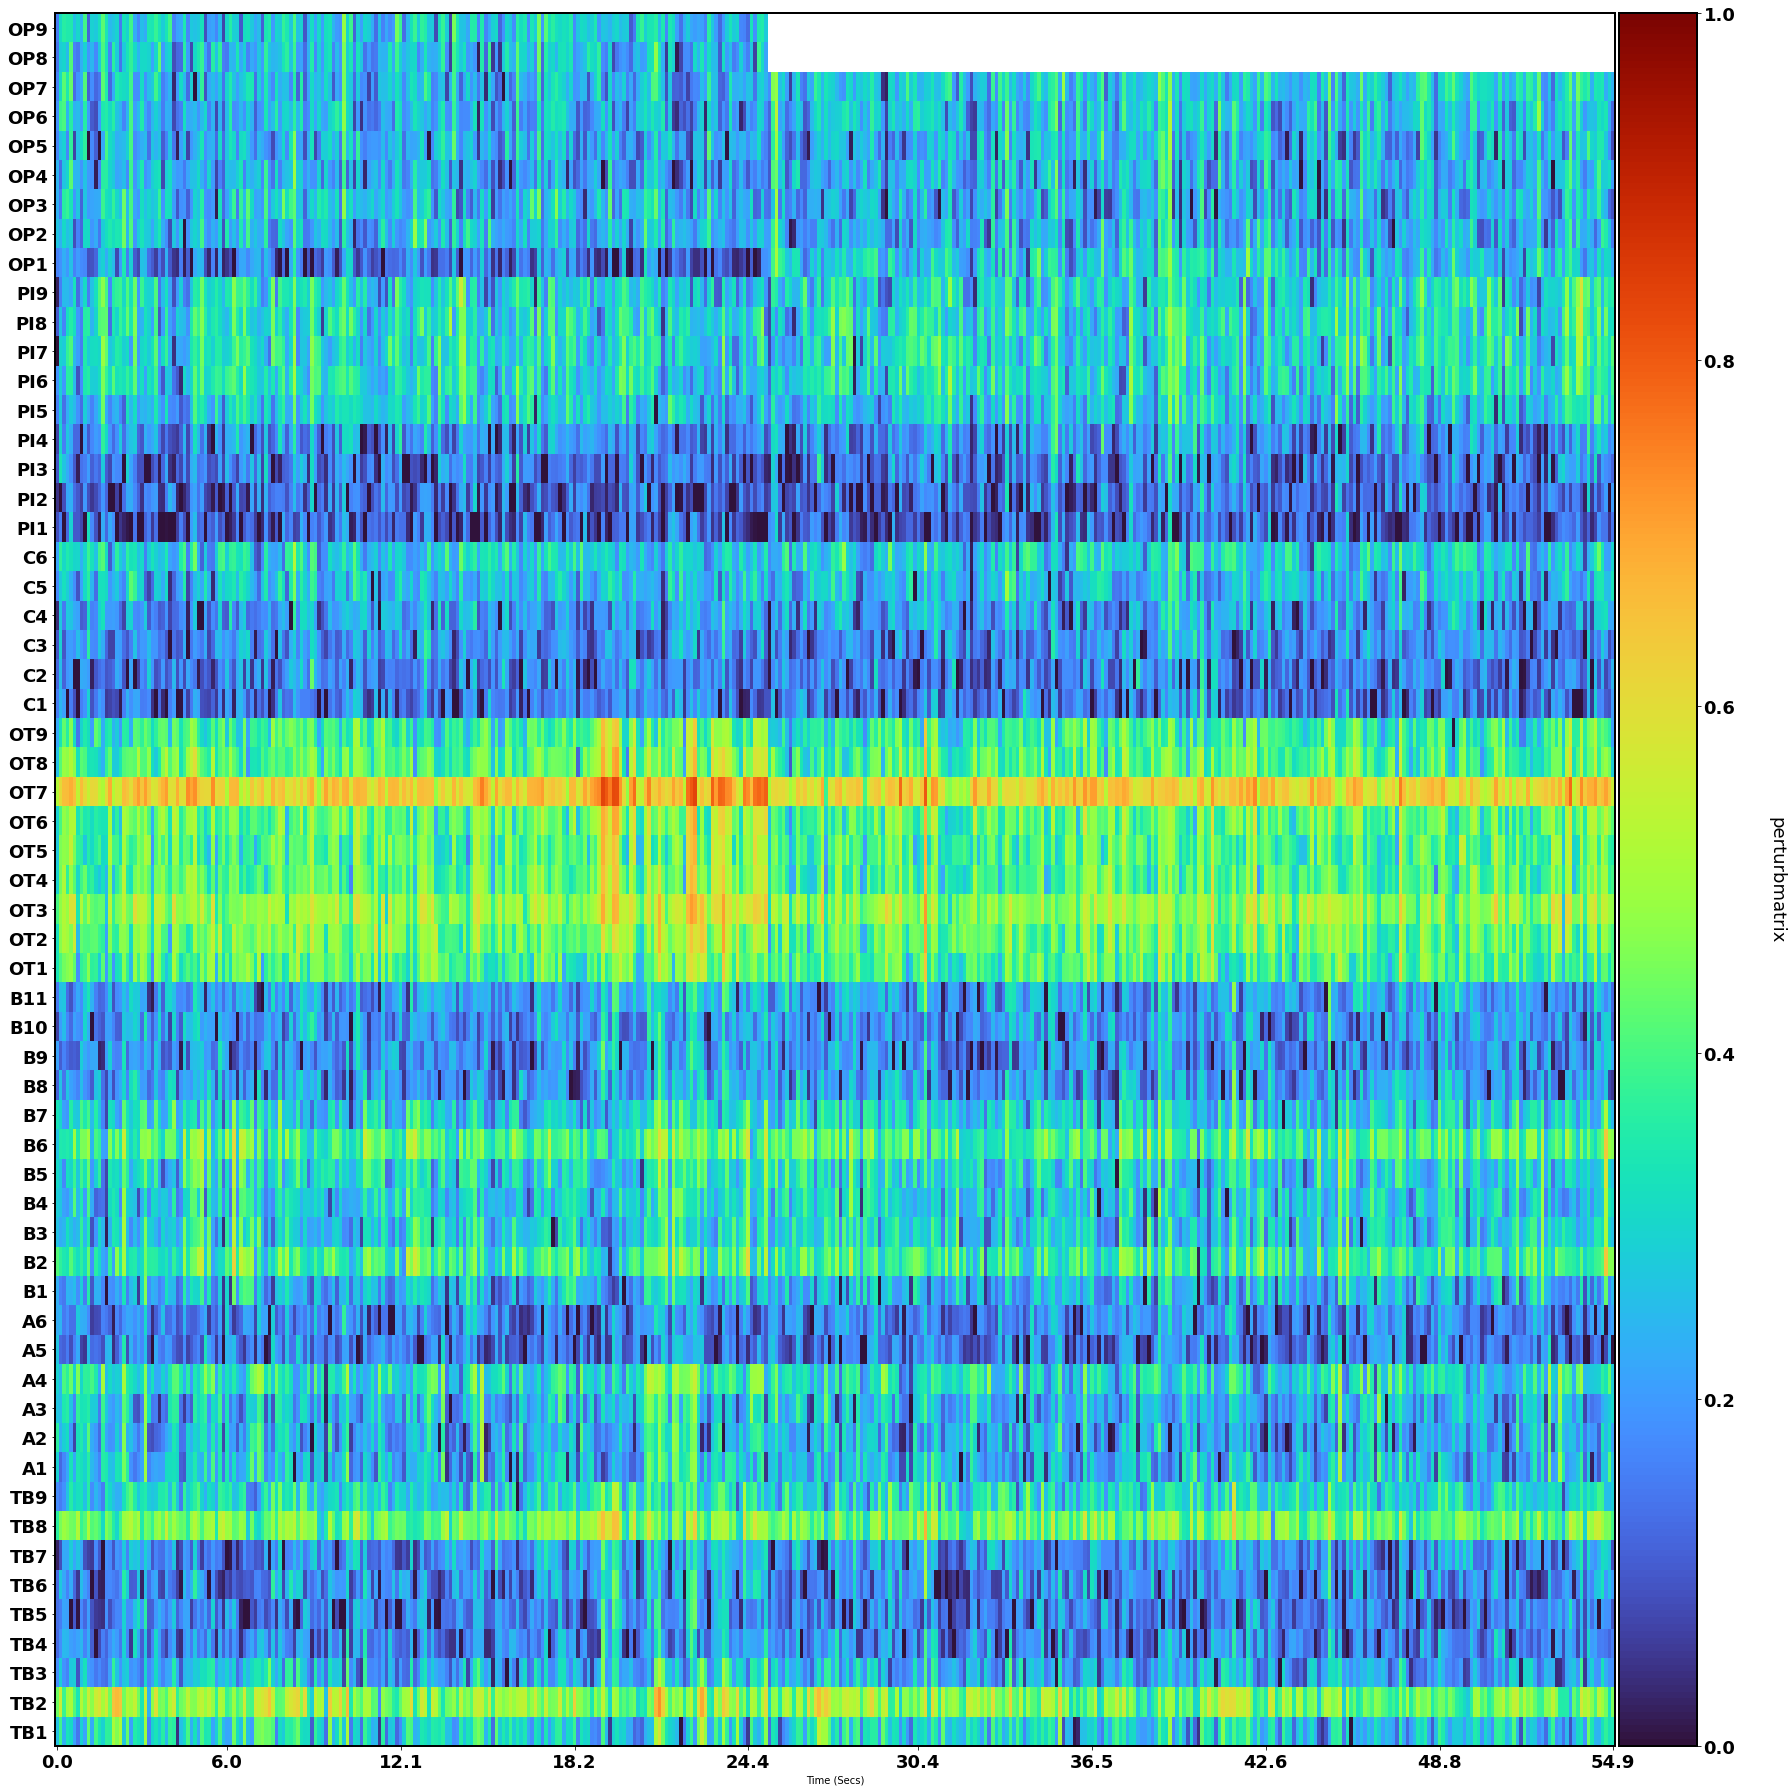

In [26]:
prefail_deriv.plot_heatmap(
    vmin=0,
    vmax=1,
    set_col_under=True,
    figure_fpath=figures_path / f"{subject}-failresection-fragilityheatmap.pdf",
)